In [1]:
import sys
from os import path
_up_one = path.abspath('../')
if _up_one not in sys.path:
    sys.path.insert(1, _up_one)

# Third-party
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.table import hstack, Table, join
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.integrate import tplquad
from scipy.optimize import minimize
from tqdm import tqdm

import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from lg_barycentric import LocalGroupBarycentric

In [34]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc)

In [50]:
row_data = []
with open('../table2.tex', 'r') as f:
    lines = f.read().split('\\ ')
    
    for line in lines:
        cols = [x.strip() for x in line.strip().split('&')]
        
        try:
            if cols[3] == '-':
                continue

            elif cols[3].startswith('$'):
                disp = float(cols[3][3:])
                limit = True

            else:
                disp = float(cols[3])
                limit = False
        except:
            print(cols)
        
        row_data.append({
            'name': cols[0],
            'vdisp': disp,
            'limit': limit
        })
        
new_table2 = at.Table(row_data)

['IC 10', '$8.6\\times 10^ {7}$', '2.65', '$\\sigma_{gas}=$8.0', '798', '251', '-52', '- \\']
['Sagittarius dIrr', '$3.5\\times 10^ {6}$', '0.91', '$\\sigma_{gas}=$10.0', '1059', '1344', '774', '- \\']
['Antlia B', '$6.3\\times 10^ {5}$', '0.72', '$\\sigma_{gas}=$7.2', '1295', '1956', '950', '- \\']
['NGC 3109', '$7.6\\times 10^ {7}$', '4.30', '$\\sigma_{gas}=$10.0', '1301', '1982', '943', '- \\']
['Antlia', '$1.3\\times 10^ {6}$', '1.20', '$\\sigma_{gas}=$6.4', '1349', '2033', '989', '- \\']
['Sextans A', '$4.4\\times 10^ {7}$', '2.47', '$\\sigma_{gas}=$8.0', '1434', '2015', '1123', '- \\']
['Leo P', '$3.9\\times 10^ {5}$', '1.20', '$\\sigma_{gas}=$8.4', '1625', '2047', '1351', '- \\']
['ESO410-G005', '$3.5\\times 10^ {6}$', '0.50', '$\\sigma_{gas}=$14.2', '1921', '1856', '1519', '- \\']
['IC 5152', '$1.4\\times 10^ {8}$', '0.97', '$\\sigma_{gas}=$36.0', '1944', '2202', '1669', '- \\\\']


In [62]:
# tbl2 = Table.read('../data/dwarf_ngas.csv')
# derp = at.join(tbl2, new_table2, keys='name')
# derp[derp['vdisp_1'] != derp['vdisp_2']]

In [64]:
tbl = Table.read('../data/dwarf_kinematics_apw.csv')
tbl = tbl[~tbl['rv'].mask]

tbl2 = Table.read('../data/dwarf_ngas.csv', header_start=1)
tbl = join(tbl, tbl2, keys='name')
tbl_c = coord.SkyCoord(ra=tbl['ra']*u.deg, dec=tbl['dec']*u.deg, 
                       distance=tbl['dist'] * u.kpc)

# Now cross-match to the existing dwarfs table:
dwarfs = Table.read('../data/dwarfs_ell.csv')
ra = (dwarfs['RA_hr']+dwarfs['RA_min']/60.+dwarfs['RA_sec']/3600) * u.hourangle
dec = (dwarfs['Dec_deg']+dwarfs['Dec_arcmin']/60+dwarfs['Dec_arcsec']/3600) * u.degree
dist = coord.Distance(distmod=dwarfs['m-M'])
dwarfs_c = coord.SkyCoord(ra, dec, distance=dist)

idx, sep, sep3d = tbl_c.match_to_catalog_3d(dwarfs_c)

idx = idx[sep < 2*u.deg]
dwarfs = dwarfs[idx]
dwarfs_c = dwarfs_c[idx]

tbl = tbl[sep < 2*u.deg]

In [65]:
C_pm = np.zeros((len(tbl), 2, 2))
C_pm[:, 0, 0] = tbl['pmra_error1']**2 + tbl['pmra_error2']**2
C_pm[:, 1, 1] = tbl['pmdec_error1']**2 + tbl['pmdec_error2']**2
C_pm[:, 0, 1] = C_pm[:, 1, 0] = np.sqrt(C_pm[:, 0, 0]) * np.sqrt(C_pm[:, 1, 1]) * tbl['pmra_pmdec_corr']

In [66]:
mw2 = gp.MilkyWayPotential()

In [67]:
n_samples = 1024

In [68]:
all_peris = []
all_vperis = []

all_apos = []
all_vapos = []

for i, row, C in tqdm(zip(range(len(tbl)), tbl, C_pm), total=len(tbl)):    
    ras = np.full(n_samples, dwarfs_c[i].ra.degree)
    decs = np.full(n_samples, dwarfs_c[i].dec.degree)
    dists = np.random.normal(row['dist'], row['dist_error'], 
                             size=n_samples) * u.kpc
    
    pmras, pmdecs = np.random.multivariate_normal([row['pmra'], row['pmdec']], C, 
                                                  size=n_samples).T * u.mas/u.yr
    rvs = np.random.normal(row['rv'], row['rv_error'], size=n_samples) * u.km/u.s
    
    c_samples = coord.SkyCoord(ra=ras*u.deg,
                               dec=decs*u.deg,
                               distance=dists,
                               pm_ra_cosdec=pmras, 
                               pm_dec=pmdecs,
                               radial_velocity=rvs)
    
    w0 = gd.PhaseSpacePosition(c_samples.transform_to(galcen_frame).data)
    orbits = mw2.integrate_orbit(w0, dt=-1, t1=0, t2=-4*u.Gyr)
    # orbits = pot.integrate_orbit(w0, dt=-1, t1=0, t2=-4*u.Gyr)
    
    r_gc = orbits.physicsspherical.r
    v_gc = np.sqrt(np.sum(orbits.v_xyz**2, axis=0))
    
    peri_idx = r_gc.argmin(axis=0)
    peris = u.Quantity([r_gc[i, j] for j, i in enumerate(peri_idx)])
    v_peris = u.Quantity([v_gc[i, j] for j, i in enumerate(peri_idx)]).to(u.km/u.s)
    
    apo_idx = r_gc.argmax(axis=0)
    apos = u.Quantity([r_gc[i, j] for j, i in enumerate(apo_idx)])
    v_apos = u.Quantity([v_gc[i, j] for j, i in enumerate(apo_idx)]).to(u.km/u.s)
    
    all_peris.append(peris)
    all_vperis.append(v_peris)
    
    all_apos.append(apos)
    all_vapos.append(v_apos)

all_peris = u.Quantity(all_peris)
all_vperis = u.Quantity(all_vperis)

all_apos = u.Quantity(all_apos)
all_vapos = u.Quantity(all_vapos)

100%|██████████| 38/38 [01:31<00:00,  2.42s/it]


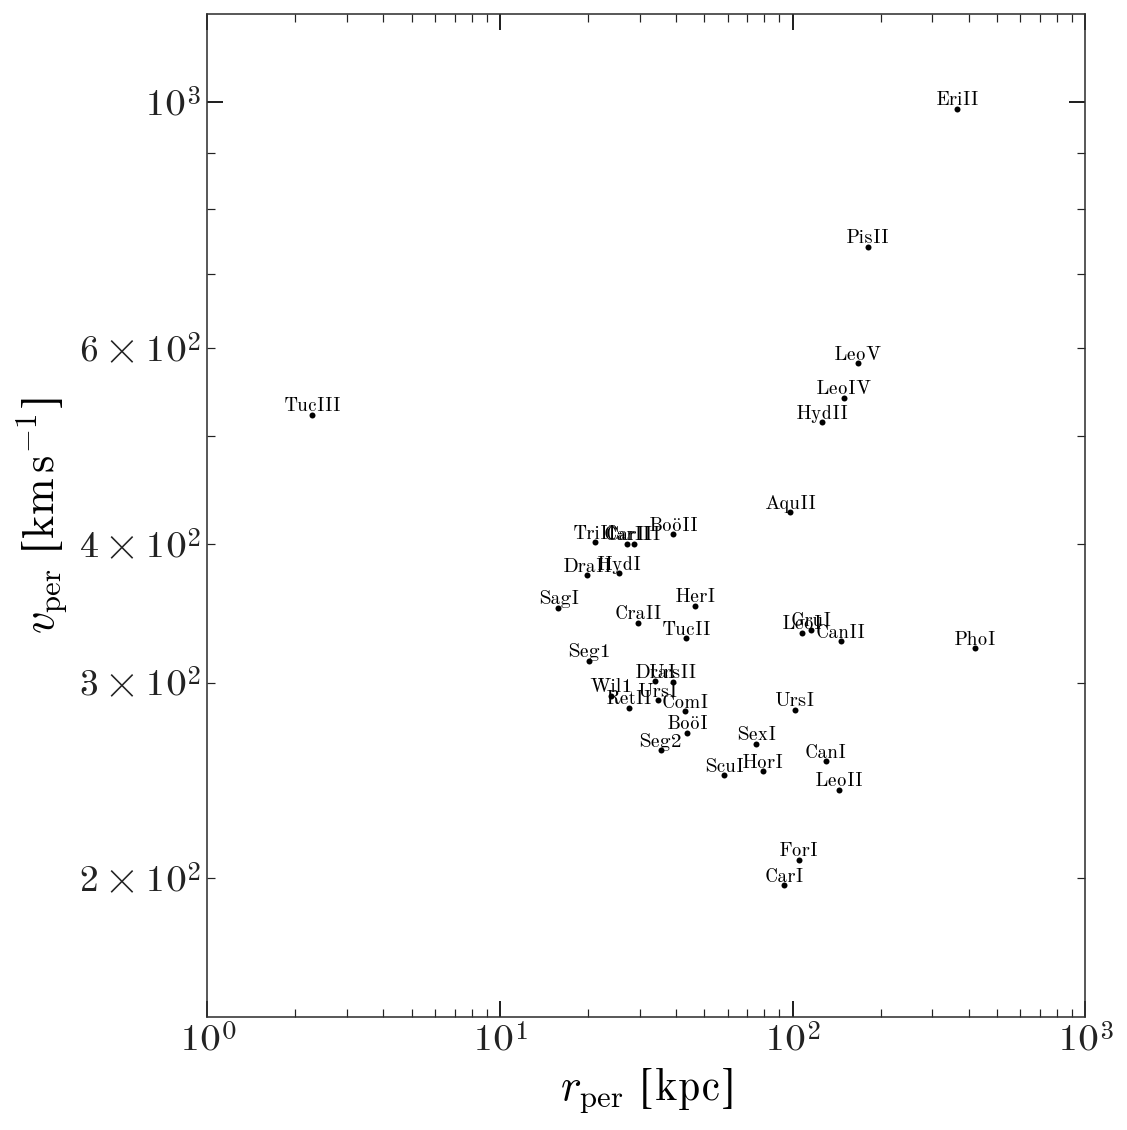

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.loglog(np.mean(all_peris, axis=1), np.mean(all_vperis, axis=1), 
          ls='none', marker='o', ms=3., color='k');

for row, rr, vv in zip(tbl, np.mean(all_peris, axis=1), np.mean(all_vperis, axis=1)):
    a, *_, b = row['name'].split(" ")
    new_name = a[:3]+b
    ax.text(rr.value, vv.value, new_name, 
            ha='center', va='bottom')

ax.set_xlabel(r'$r_{\rm per}$ ' + '[kpc]')
ax.set_ylabel(r'$v_{\rm per}$ ' + '[{:latex_inline}]'.format(u.km/u.s))

ax.set_xlim(1, 1e3)
ax.set_ylim(150, 1.2e3)

fig.set_facecolor('w')
fig.tight_layout()

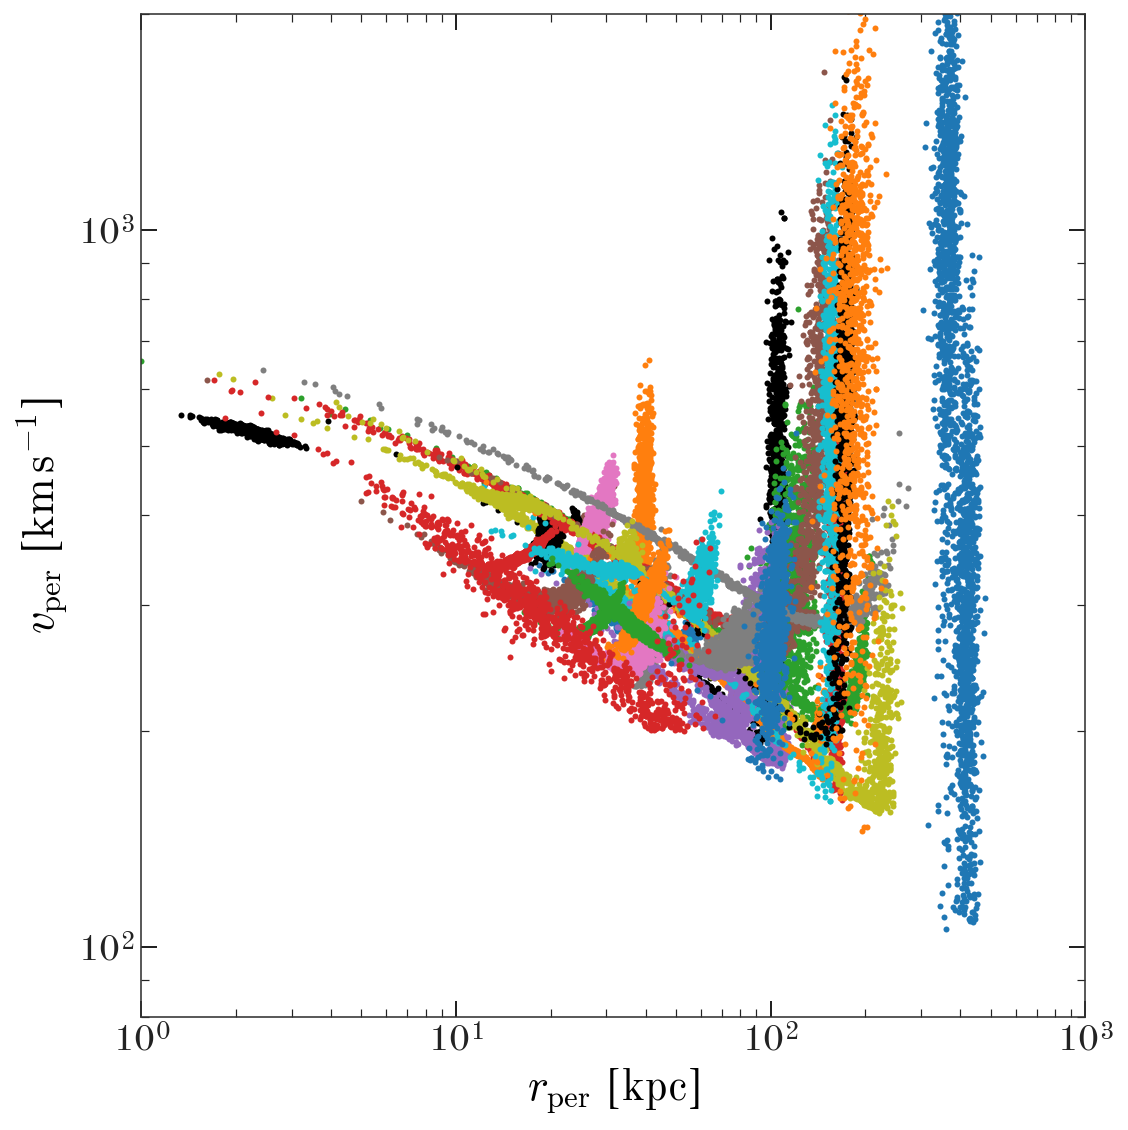

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.loglog(all_peris.T, all_vperis.T, ls='none', marker='o', ms=3.);
ax.set_xlabel(r'$r_{\rm per}$ ' + '[kpc]')
ax.set_ylabel(r'$v_{\rm per}$ ' + '[{:latex_inline}]'.format(u.km/u.s))
ax.set_xlim(1, 1e3)
ax.set_ylim(80, 2e3)
fig.set_facecolor('w')
fig.tight_layout()

In [71]:
# vel. disp. values
# s = tbl['vdisp'] * u.km/u.s
s = np.random.normal(tbl['vdisp'], 0.2*tbl['vdisp'], size=all_vperis.T.shape).T * u.km/u.s

# n_gas = tbl['ngas'][:, None] / u.cm**3
n_gas = 0.35 / u.cm**3
# n_gas = np.random.uniform(0.1, 0.6, size=(len(tbl), n_samples)) / u.cm**3

vsat_p = all_vperis
vsat_a = all_vapos

n_halo_p = s**2 * n_gas / (vsat_p**2)
n_halo_a = s**2 * n_gas / (vsat_a**2)

n_halo_p_err = np.std(n_halo_p, axis=1)
n_halo_a_err = np.std(n_halo_a, axis=1)
n_halo_p = np.mean(n_halo_p, axis=1)
n_halo_a = np.mean(n_halo_a, axis=1)

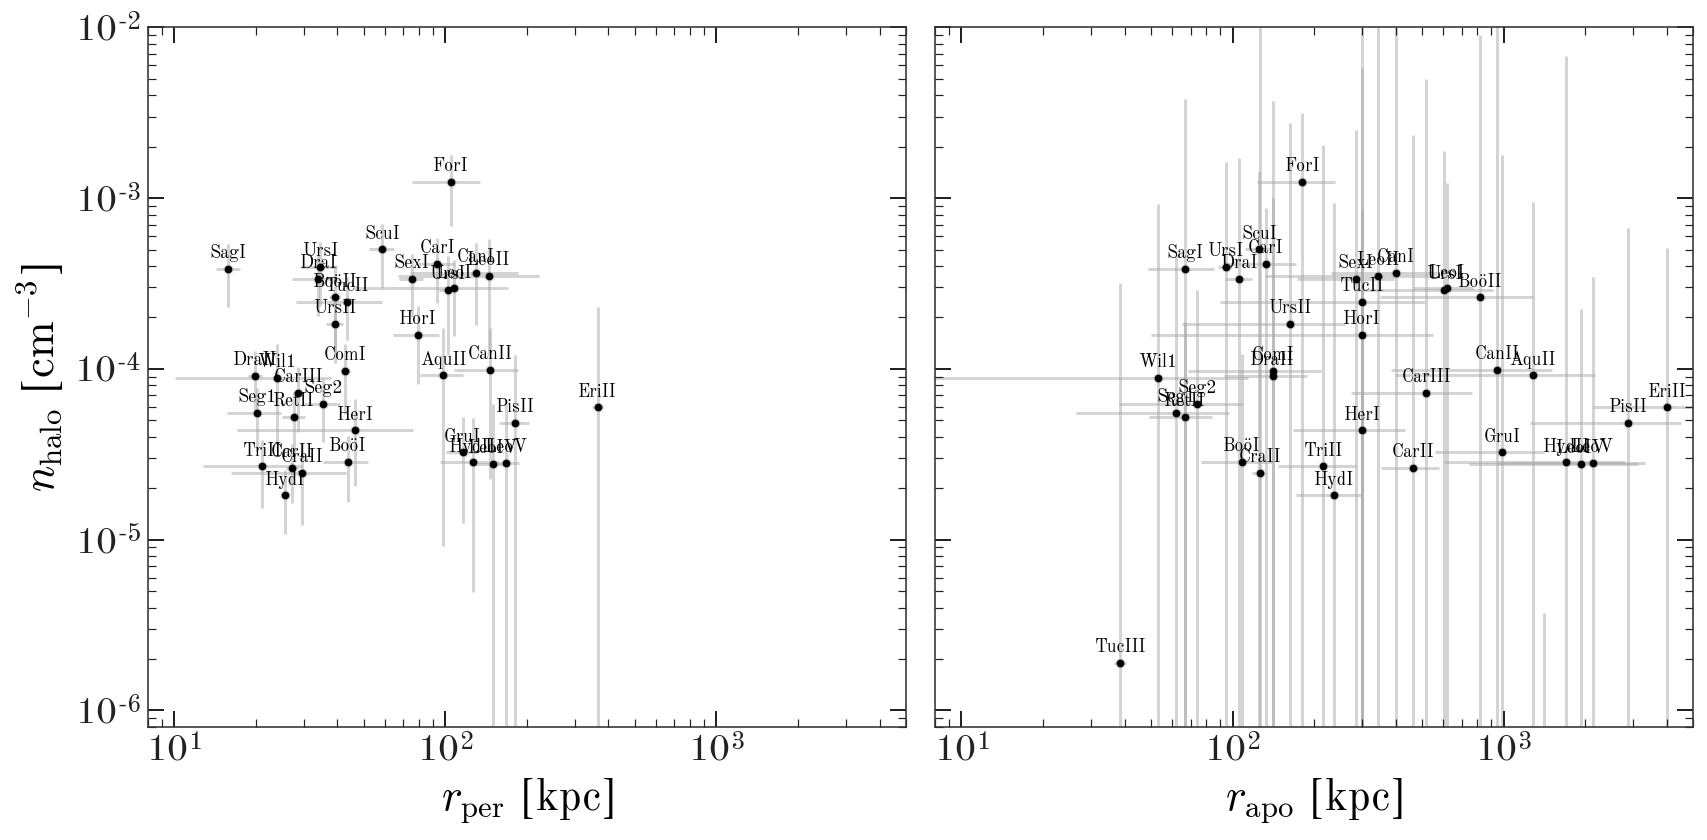

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True, sharey=True)

ax = axes[0]

ax.scatter(np.mean(all_peris, axis=1), n_halo_p.value, c='k', s=8)
ax.errorbar(np.mean(all_peris, axis=1).value, n_halo_p.value, 
            xerr=np.std(all_peris, axis=1).value,
            yerr=n_halo_p_err.value,
            marker='o', ls='none', c='#aaaaaa', zorder=-100, alpha=0.5)

for row, rr, yy in zip(tbl, np.mean(all_peris, axis=1), n_halo_p):
    if yy.value == 0 or yy.value < 1e-5:
        continue
        
    a, *_, b = row['name'].split(" ")
    new_name = a[:3] + b
    ax.text(rr.value, yy.value+0.1*yy.value, new_name, 
            ha='center', va='bottom', fontsize=9)

ax.set_xlabel(r'$r_{\rm per}$ ' + '[kpc]')
ax.set_ylabel(r'$n_{\rm halo}$' + ' [{:latex_inline}]'.format(u.cm**-3))

# ---

ax = axes[1]

ax.scatter(np.mean(all_apos, axis=1), n_halo_p.value, c='k', s=8)
ax.errorbar(np.mean(all_apos, axis=1).value, n_halo_p.value, 
            xerr=np.std(all_apos, axis=1).value,
            yerr=n_halo_a_err.value,
            marker='o', ls='none', c='#aaaaaa', zorder=-100, alpha=0.5)

for row, rr, yy in zip(tbl, np.mean(all_apos, axis=1), n_halo_p):
    if yy.value == 0 or yy.value < 1e-6:
        continue
        
    a, *_, b = row['name'].split(" ")
    new_name = a[:3] + b
    ax.text(rr.value, yy.value+0.1*yy.value, new_name, 
            ha='center', va='bottom', fontsize=9)

ax.set_xlabel(r'$r_{\rm apo}$ ' + '[kpc]')
# ax.set_ylabel(r'$n_{\rm halo}$' + ' [{:latex_inline}]'.format(u.cm**-3))

ax.set_xlim(8, 5e3)
ax.set_ylim(8e-7, 1e-2)
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()

fig.savefig('../plots/rper_rapo_nhalo_0.35.pdf')

In [82]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# ax.scatter(np.mean(all_apos, axis=1), n_halo_p.value, c='k')
# ax.errorbar(np.mean(all_apos, axis=1).value, n_halo_p.value, 
#             xerr=np.std(all_apos, axis=1).value,
#             yerr=n_halo_a_err.value,
#             marker='o', ls='none', c='#aaaaaa', zorder=-100, alpha=0.5)

# for row, rr, yy in zip(tbl, np.mean(all_apos, axis=1), n_halo_p):
#     if yy.value == 0 or yy.value < 1e-6:
#         continue
        
#     a, *_, b = row['name'].split(" ")
#     new_name = a[:3] + b
#     ax.text(rr.value, yy.value+0.1*yy.value, new_name, 
#             ha='center', va='bottom')

# ax.set_xlabel(r'$r_{\rm apo}$ ' + '[kpc]')
# ax.set_ylabel(r'$n_{\rm halo}$' + ' [{:latex_inline}]'.format(u.cm**-3))

# ax.set_xlim(8, 5e3)
# ax.set_ylim(8e-7, 1e-2)
# ax.set_yscale('log')
# ax.set_xscale('log')

# fig.set_facecolor('w')
# fig.tight_layout()

# fig.savefig('../plots/rapo_nhalo_0.35.pdf')
# # fig.savefig('../plots/rapo_nhalo_0.1-0.6.pdf')

In [85]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# ax.scatter(np.mean(all_peris, axis=1), n_halo_p.value, c='k', s=8)
# ax.errorbar(np.mean(all_peris, axis=1).value, n_halo_p.value, 
#             xerr=np.std(all_peris, axis=1).value,
#             yerr=n_halo_p_err.value,
#             marker='o', ls='none', c='#aaaaaa', zorder=-100, alpha=0.5)

# for row, rr, yy in zip(tbl, np.mean(all_peris, axis=1), n_halo_p):
#     if yy.value == 0 or yy.value < 1e-5:
#         continue
        
#     a, *_, b = row['name'].split(" ")
#     new_name = a[:3] + b
#     ax.text(rr.value, yy.value+0.1*yy.value, new_name, 
#             ha='center', va='bottom', fontsize=9)

# ax.set_xlabel(r'$r_{\rm per}$ ' + '[kpc]')
# ax.set_ylabel(r'$n_{\rm halo}$' + ' [{:latex_inline}]'.format(u.cm**-3))

# ax.set_xlim(8, 1e3)
# ax.set_ylim(8e-7, 1e-2)
# ax.set_yscale('log')
# ax.set_xscale('log')

# fig.set_facecolor('w')
# fig.tight_layout()

# fig.savefig('../plots/rper_nhalo_0.35.pdf')
# # fig.savefig('../plots/rper_nhalo_0.1-0.6.pdf')

In [88]:
kin_tbl = Table()

kin_tbl['id'] = dwarfs['id']

kin_tbl['r_per'] = np.mean(all_peris, axis=1).to(u.kpc)
kin_tbl['r_per_err'] = np.std(all_peris, axis=1).to(u.kpc)

kin_tbl['v_per'] = np.mean(vsat_p, axis=1).to(u.km/u.s)
kin_tbl['v_per_err'] = np.std(vsat_p, axis=1).to(u.km/u.s)

kin_tbl['r_apo'] = np.mean(all_apos, axis=1).to(u.kpc)
kin_tbl['r_apo_err'] = np.std(all_apos, axis=1).to(u.kpc)

kin_tbl['rho_cgm_est'] = n_halo_p
kin_tbl['rho_cgm_est_err'] = n_halo_p_err

In [91]:
full_dwarfs = ascii.read('../data/dwarfs_ell.csv')
joined = join(full_dwarfs, kin_tbl, keys='id', join_type='outer')
joined.write('../data/dwarfs_ell_orbits.csv')

In [93]:
joined

id,GalaxyName,RA_hr,RA_min,RA_sec,Dec_deg,Dec_arcmin,Dec_arcsec,EB-V,m-M,m-M_err,vh(km/s),Vmag,Vmag_err,PA,e=1-b/a,muVo,rh('),rh_err_pos,rh_err_neg,vsig_s,vsig_err,vrot_s,vrot_s_err,MHI_mcconnachie,Data,Key,vsig_g,vsig_g_err,vrot_g,Notes,dist_kpc,MHI_computed,MHI_source,MHI_type,1sigma,notes/image/limit,mw_dist,m31_dist,r_ell,ell_surf_dist,r_per,r_per_err,v_per,v_per_err,r_apo,r_apo_err,rho_cgm_est,rho_cgm_est_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,km / s,km / s,kpc,kpc,1 / cm3,1 / cm3
int64,str16,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str3,float64,float64,float64,str785,float64,float64,str7,str13,float64,str165,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,SagittariusdSph,18,55,19.5,-30,32,43,0.153,17.1,0.15,140.0,3.6,0.3,102.0,0.64,25.2,342.0,12.0,12.0,11.4,0.7,0.0,0.0,0.0,x,u,0.0,0.0,0.0,"(I don’t understand where the limit in GP or Mateo is from, Spekkens has <7880 from GASS, K94 has <10000) SKIP THERE ARE DEEPER LIMITS FOR THE CORE",26.302679918953842,--,--,--,--,use lit.,18.422410659855245,786.9893232008902,458.15294544765044,-251.95276258520218,15.825825958328297,1.6007461025924705,350.2329924796518,8.345173766636572,66.86514428802326,18.259990570326735,0.00038526088200306825,0.0001536014023382216
3,TucanaIII,23,56,36.0,-59,36,0,9.999,17.01,0.16,-102.0,14.6,0.4,999.9,9.99,99.9,6.0,0.8,0.6,0.1,99.9,99.9,99.9,99.9,x,u,99.9,99.9,999.9,"- Simon et al. 2017 V_hel = -102 km/s, velocity dispersion of 0.1 km/s, D=25 kpc",25.234807724805755,91.89114490090122,hi4pi,upper_limit,0.0203817,ok,23.286454074572276,783.8326858955157,456.64753927606586,-247.7271120715122,2.2826397645049528,0.3203841129747221,522.7123882553165,9.865091782114646,38.45156331758087,1.9539946622563482,1.9054561792928809e-06,7.856502163405161e-07
4,DracoII,15,52,47.6,64,33,55,0.016,16.9,0.3,-347.0,14.0,0.8,70.0,0.24,99.9,2.7,1.0,0.8,2.9,99.9,99.9,99.9,99.9,x,u,99.9,99.9,999.9,"- Martin et al. 2016 V_hel -347 km/s, dispersion of 2.9 km/s, (9 stars)",23.988329190194897,70.60196425864088,hi4pi,upper_limit,0.0173294,ok,26.199691455978176,770.261602688511,442.9946820648218,-251.6817525484683,19.86603602574047,1.1371669505080957,374.94479735472623,13.188333598888086,140.5364977586423,47.31578581618644,9.081363614943353e-05,3.60184376144366e-05
5,Segue(I),10,7,4.0,16,4,55,0.031,16.8,0.2,208.5,15.3,0.8,85.0,0.48,27.6,4.4,1.2,0.6,3.9,0.8,0.0,0.0,--,gs,u,0.0,0.0,0.0,"148+18s.mir stdev (0.04K/9.1K/Jy)*5 = 0.02 Jy limit (from standard sqrt(.74/9.6) would have expected something more like 0.02K, it looks like the scan artifacts have probably caused this, emphasizes importance of checking each. yes the baseline is really nasty, but it also looks like a 0.2K would stick out easily) Spekkens quotes 5.5 mJy (5 sigma) so hers is much deeper, all of them look like they would be much deeper…. in theory should reach the alfalfa level of 2 mJy (1 sigma) in some regions of DR1. Ah but she is using 15 km/s smooth (and width). I get a segue mass limit of 25 with 0.02*10*.236*23^2 so factor of 10 on GP. Probably stick with my method and just footnote Spekkens limit in table or text I DON’T KNOW I THINK WHEN DEEPER WITH HER PAPER JUST ADOPT THAT",22.90867652767775,--,--,upper_limit,0.017123,ok,27.892321264551313,787.9720949392585,462.35633730666996,-242.59352245286604,20.168628254815957,4.562785369855884,313.8928566545463,15.570738015255758,61.94598159176852,35.41529132778813,5.51197199744901e-05,2.204835599774934e-05
6,Reticulum2,3,35,42.1,-54,2,57,9.999,17.4,0.2,64.0,14.7,0.1,71.0,0.59,99.9,3.64,0.21,0.12,3.4,99.9,99.9,99.9,99.9,x,u,99.9,99.9,999.9,"- Walker et al., Koposov et al. (2015), V_hel=64 km/s, dispersion 3.2-3.6 km/s, D=30 kpc",30.19951720402013,132.74892698458365,hi4pi,upper_limit,0.0205588,ok,31.663735894087903,785.9287546746662,462.1219412447442,-239.23978963295104,27.6786

---

In [88]:
mw2.mass_enclosed([250., 0, 0])

<Quantity [1.09650474e+12] solMass>

In [89]:
m31_c = coord.SkyCoord(10.68470833, 41.268, unit=u.deg)

In [25]:
all_orbits_c = []
all_orbits_names = []
frac_m31 = []
for row, C, apo in tqdm(zip(tbl, C_pm, np.mean(all_apos, axis=1)), total=len(tbl)):   
    if apo < 300*u.kpc:
        continue
    
    ras = np.full(n_samples, row['ra'])
    decs = np.full(n_samples, row['dec'])
    dists = np.random.normal(row['dist'], row['dist_error'], 
                             size=n_samples) * u.kpc
    
    pmras, pmdecs = np.random.multivariate_normal([row['pmra'], row['pmdec']], C, 
                                                  size=n_samples).T * u.mas/u.yr
    rvs = np.random.normal(row['rv'], row['rv_error'], size=n_samples) * u.km/u.s
    
    c_samples = coord.SkyCoord(ra=ras*u.deg,
                               dec=decs*u.deg,
                               distance=dists,
                               pm_ra_cosdec=pmras, 
                               pm_dec=pmdecs,
                               radial_velocity=rvs)
    
    w0 = gd.PhaseSpacePosition(c_samples.transform_to(galcen_frame).data)
    orbits = mw2.integrate_orbit(w0, dt=-1, t1=0, t2=-2*u.Gyr)
    # orbits = pot.integrate_orbit(w0, dt=-1, t1=0, t2=-4*u.Gyr)
    
    orbits_c = orbits.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)
    all_orbits_c.append(orbits_c)
    all_orbits_names.append(row['name'])
    
    mask = (orbits_c.separation(m31_c) < 20*u.deg).any(axis=0)
    frac_m31.append(mask.sum() / n_samples)

100%|██████████| 39/39 [00:24<00:00,  1.57it/s]


In [26]:
for name, f in zip(all_orbits_names, frac_m31):
    print(name, f)

Aquarius II 0.0390625
Boötes II 0.0
Canes Venatici I 0.001953125
Canes Venatici II 0.0
Carina II 0.9794921875
Carina III 0.0
Crater I 0.0771484375
Eridanus II 0.0029296875
Grus I 0.0
Hercules I 0.318359375
Hydra II 0.1025390625
Leo I 0.05078125
Leo II 0.0283203125
Leo IV 0.0146484375
Leo V 0.0146484375
Phoenix I 0.001953125
Pisces II 0.365234375
Tucana II 0.0
Ursa Major I 0.0


In [57]:
for orbits_c, name in zip(all_orbits_c, all_orbits_names):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(orbits_c.ra, orbits_c.dec, 
            marker='.', ls='none')
    ax.scatter(m31_c.ra, m31_c.dec, marker='o', s=150, color='#aaaaaa', zorder=10)
    ax.set_xlim(360, 0)
    ax.set_ylim(-90, 90)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    fig.savefig('../plots/sky_orbits_{}.png'.format(name), dpi=250)
    plt.close(fig)

---

In [149]:
names = ['peri', 'peri_err1', 'peri_err2', 'apo', 'apo_err1', 'apo_err2'] + ['x'+str(i) for i in range(12)]
fritz_orbits = ascii.read('../data/Fritz18_table3.txt', names=names)

In [150]:
c = coord.SkyCoord(ra=fritz18['ra']*u.deg,
                   dec=fritz18['dec']*u.deg,
                   distance=fritz18['dist']*u.kpc,
                   pm_ra_cosdec=fritz18['pmra']*u.mas/u.yr,
                   pm_dec=fritz18['pmdec']*u.mas/u.yr,
                   radial_velocity=fritz18['rv']*u.km/u.s)
galcen = c.transform_to(galcen_frame)

In [151]:
w0 = gd.PhaseSpacePosition(galcen.data)

In [152]:
orbits = H.integrate_orbit(w0, dt=-5*u.Myr, n_steps=2000)

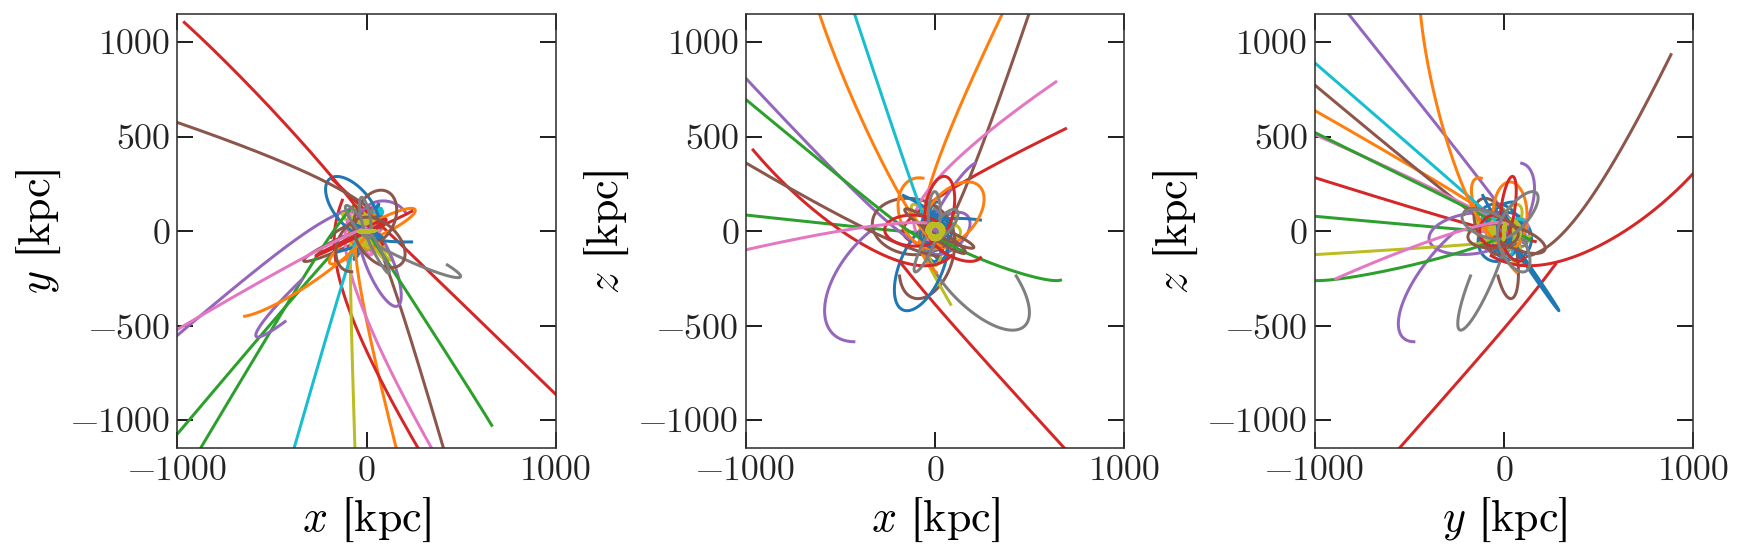

In [153]:
fig = orbits.plot()
for ax in fig.axes:
    ax.set_xlim(-1000, 1000)
    ax.set_ylim(-1000, 1000)

In [154]:
for i, name in enumerate(fritz18['name']):
    print('{} {:.0f} {:.0f} fritz: {:.0f} {:.0f}'
          .format(name, 
                  orbits[:, i].pericenter(), orbits[:, i].apocenter(),
                  fritz_orbits['peri'][i], fritz_orbits['apo'][i]))

Aquarius II 100 kpc 174 kpc fritz: 95 190
Boötes I 57 kpc nan kpc fritz: 32 77
Boötes II nan kpc nan kpc fritz: 38 167
Canes Venatici I 169 kpc nan kpc fritz: 54 254
Canes Venatici II 164 kpc nan kpc fritz: 85 234
Carina I 31 kpc nan kpc fritz: 60 106
Carina II 28 kpc 130 kpc fritz: 26 118
Carina III 30 kpc 138 kpc fritz: 28 106
Coma Berenices I 31 kpc 202 kpc fritz: 42 63
Crater I 26 kpc 145 kpc fritz: 46 153
Crater II 18 kpc 117 kpc fritz: 18 124
Draco I 27 kpc 98 kpc fritz: 28 91
Draco II 22 kpc 80 kpc fritz: 19 62
Eridanus II 349 kpc nan kpc fritz: 356 70846
Fornax I 75 kpc 429 kpc fritz: 58 147
Grus I 95 kpc 372 kpc fritz: 58 329
Hercules I 111 kpc nan kpc fritz: 14 187
Horologium I 77 kpc 731 kpc fritz: 70 94
Hydra II 93 kpc nan kpc fritz: 116 676
Hydrus I 24 kpc 60 kpc fritz: 25 73
Leo I 56 kpc 535 kpc fritz: 45 590
Leo II 96 kpc 342 kpc fritz: 41 238
Leo IV 141 kpc nan kpc fritz: 150 1794
Leo V 164 kpc nan kpc fritz: 165 4079
Phoenix I nan kpc 946 kpc fritz: 263 1549
Pisces II 